# 03 - EDA v2: Corrigir Assimetria de Transicoes

## Problemas identificados no modelo atual (GNB v5, 14 features)

1. **57% das features sao skew/kurtosis** (8 de 14) - momentos de alta ordem convergem lentamente
2. **Variancia assimetrica entre classes** - HIGH tem variancia 12-27x maior que LOW/MEDIUM
3. **MISMATCH peak treino vs inferencia** - Python usa `np.max(np.abs(arr))`, JS usa `P95(|arr|)`

## Fontes de dados suportadas

O notebook tenta carregar dados nesta ordem de prioridade:
1. **Banco de dados MySQL** (`iot_mpu6050`) - dados brutos ponto-a-ponto
2. **CSV de dados brutos** (`output/data/raw_sensor_data_*.csv`) - backup salvo pelo notebook 01
3. **CSV de features pre-extraidas** (`output/data/features_latest.csv`) - modo parcial

No modo **features_only** (opcao 3), as celulas de convergencia temporal (5) e simulacao de transicao (10, 10b) sao puladas, pois requerem dados ponto-a-ponto. A selecao do modelo usa apenas acuracia CV.

## Estrategia
- Corrigir peak para P95 (alinhar com JS)
- Analisar convergencia temporal das features
- Selecionar features com restricao de convergencia
- Comparar conjuntos A (baseline), B (max 3 skew/kurtosis), C (zero skew/kurtosis)
- Testar StandardScaler + GNB
- Simular transicoes e medir simetria

**Saidas:**
- Modelo GNB otimizado para transicoes simetricas
- `config/feature_config.json` atualizado
- Modelo JSON exportado

In [1]:
# =============================================================================
# Celula 1: Setup e Imports
# =============================================================================
import os
import json
import time
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats as scipy_stats
from scipy.stats import skew, kurtosis, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- CONFIGURACAO ---
DB_CONFIG = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'iot_mpu6050',
}

SAMPLE_RATE_HZ = 5
WINDOW_SIZE = 100
STEP_SIZE = 20
ANOVA_ALPHA = 0.05
CORRELATION_THRESHOLD = 0.85

SENSOR_AXES = ['accel_x_g', 'accel_y_g', 'accel_z_g', 'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps']

TIMESTAMP_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
OUTPUT_DATA = 'output/data'
OUTPUT_FIGURES = 'output/figures'
OUTPUT_METRICS = 'output/metrics'
OUTPUT_MODELS = 'output/models'
CONFIG_DIR = os.path.join('..', 'config')

for d in [OUTPUT_DATA, OUTPUT_FIGURES, OUTPUT_METRICS, OUTPUT_MODELS, CONFIG_DIR]:
    os.makedirs(d, exist_ok=True)

# --- FONTE DE DADOS ---
# Prioridade: 1) Banco de dados, 2) CSV de dados brutos, 3) CSV de features pre-extraidas
# Se o banco nao estiver disponivel, usa os CSVs salvos pelo notebook 01
RAW_CSV_FALLBACK = 'output/data/raw_sensor_data_20260131_131219.csv'
FEATURES_CSV_FALLBACK = 'output/data/features_latest.csv'

print(f'Timestamp: {TIMESTAMP_STR}')
print(f'Window: {WINDOW_SIZE} pontos = {WINDOW_SIZE/SAMPLE_RATE_HZ:.0f}s, Step: {STEP_SIZE} pontos = {STEP_SIZE/SAMPLE_RATE_HZ:.0f}s')

Timestamp: 20260131_203027
Window: 100 pontos = 20s, Step: 20 pontos = 4s


In [23]:
# =============================================================================
# Celula 2: Carga dos dados brutos (banco ou CSV fallback)
# =============================================================================

DATA_SOURCE = None  # sera 'db', 'raw_csv', ou 'features_only'
df_raw = None

# Tentativa 1: Banco de dados
try:
    import pymysql
    conn = pymysql.connect(**DB_CONFIG)
    query = """
    SELECT id, timestamp, temperature, vibration,
           accel_x_g, accel_y_g, accel_z_g,
           gyro_x_dps, gyro_y_dps, gyro_z_dps,
           fan_state, collection_id
    FROM sensor_data
    WHERE fan_state IN ('LOW', 'MEDIUM', 'HIGH')
    ORDER BY timestamp ASC
    """
    df_raw = pd.read_sql(query, conn)
    conn.close()
    if len(df_raw) > 0:
        DATA_SOURCE = 'db'
        print(f'Dados carregados do BANCO DE DADOS: {len(df_raw)} amostras')
    else:
        df_raw = None
        print('Banco de dados vazio, tentando CSV...')
except Exception as e:
    print(f'Banco de dados indisponivel ({e.__class__.__name__}), tentando CSV...')

# Tentativa 2: CSV de dados brutos (salvo pelo notebook 01)
if df_raw is None and os.path.exists(RAW_CSV_FALLBACK):
    df_raw = pd.read_csv(RAW_CSV_FALLBACK)
    if len(df_raw) > 0 and 'fan_state' in df_raw.columns:
        DATA_SOURCE = 'raw_csv'
        print(f'Dados carregados do CSV bruto: {RAW_CSV_FALLBACK} ({len(df_raw)} amostras)')
    else:
        df_raw = None

# Resultado
if df_raw is not None:
    print(f'Fonte: {DATA_SOURCE}')
    print(f'Classes: {df_raw["fan_state"].value_counts().to_dict()}')
    # Garantir que colunas de sensor existem
    missing = [ax for ax in SENSOR_AXES if ax not in df_raw.columns]
    if missing:
        print(f'AVISO: Colunas faltando no CSV: {missing}')
else:
    print('Dados brutos NAO disponiveis (nem banco, nem CSV bruto).')
    print(f'Celulas 3-5 e 10-10b serao puladas. Usando features pre-extraidas de: {FEATURES_CSV_FALLBACK}')
    DATA_SOURCE = 'features_only'

Dados carregados do BANCO DE DADOS: 6335 amostras
Fonte: db
Classes: {'MEDIUM': 2125, 'LOW': 2110, 'HIGH': 2100}


In [24]:
# =============================================================================
# Celula 3: Validacao e filtro temporal
# SKIP se DATA_SOURCE == 'features_only'
# =============================================================================

df = None  # dados brutos filtrados (None se features_only)

if DATA_SOURCE in ('db', 'raw_csv'):
    df_raw['timestamp_s'] = df_raw['timestamp'].copy()
    if df_raw['timestamp_s'].median() > 1e12:
        df_raw['timestamp_s'] = df_raw['timestamp_s'] / 1000.0

    df_raw['relative_time_s'] = 0.0
    for cls in df_raw['fan_state'].unique():
        mask = df_raw['fan_state'] == cls
        t0 = df_raw.loc[mask, 'timestamp_s'].min()
        df_raw.loc[mask, 'relative_time_s'] = df_raw.loc[mask, 'timestamp_s'] - t0

    duration_per_class = df_raw.groupby('fan_state')['relative_time_s'].max()
    common_window_s = duration_per_class.min()

    df = df_raw[df_raw['relative_time_s'] <= common_window_s].copy()

    print(f'Amostras ANTES do filtro: {len(df_raw)}')
    print(f'Amostras APOS o filtro:  {len(df)}')
    print(f'Amostras por classe: {df.groupby("fan_state").size().to_dict()}')
    print(f'Janela comum: {common_window_s:.2f}s (~{common_window_s/60:.1f} min)')
else:
    print('SKIP: Dados brutos nao disponiveis (modo features_only).')

Amostras ANTES do filtro: 6335
Amostras APOS o filtro:  6327
Amostras por classe: {'HIGH': 2098, 'LOW': 2110, 'MEDIUM': 2119}
Janela comum: 541.25s (~9.0 min)


In [25]:
# =============================================================================
# Celula 4: Feature Engineering CORRIGIDO
#
# CORRECAO: peak usa P95(|arr|) para alinhar com classifier.js
# Antes: peak = np.max(np.abs(arr))  <-- mismatch com JS
# Agora: peak = np.percentile(np.abs(arr), 95)  <-- alinhado com JS
#
# Se DATA_SOURCE == 'features_only': carrega features_latest.csv
# =============================================================================

def compute_features_v2(window_values, axis_name):
    """Calcula 11 metricas estatisticas para uma janela de dados.
    CORRECAO v2: peak usa P95 (alinhado com classifier.js Stats.peak)."""
    arr = np.asarray(window_values, dtype=np.float64)
    n = len(arr)
    if n == 0:
        return {}

    mean_val = np.mean(arr)
    std_val = np.std(arr, ddof=0)
    skew_val = float(skew(arr, bias=True))
    kurt_val = float(kurtosis(arr, fisher=True, bias=True))
    rms_val = np.sqrt(np.mean(arr ** 2))

    abs_arr = np.abs(arr)
    peak_val = np.percentile(abs_arr, 95)  # CORRECAO: P95

    root_amplitude = (np.mean(np.sqrt(abs_arr))) ** 2
    mean_abs = np.mean(abs_arr)
    crest_factor = peak_val / rms_val if rms_val > 1e-10 else 0.0
    shape_factor = rms_val / mean_abs if mean_abs > 1e-10 else 0.0
    impulse_factor = peak_val / mean_abs if mean_abs > 1e-10 else 0.0
    clearance_factor = peak_val / root_amplitude if root_amplitude > 1e-10 else 0.0

    return {
        f'{axis_name}_mean': mean_val,
        f'{axis_name}_std': std_val,
        f'{axis_name}_skew': skew_val,
        f'{axis_name}_kurtosis': kurt_val,
        f'{axis_name}_rms': rms_val,
        f'{axis_name}_peak': peak_val,
        f'{axis_name}_root_amplitude': root_amplitude,
        f'{axis_name}_crest_factor': crest_factor,
        f'{axis_name}_shape_factor': shape_factor,
        f'{axis_name}_impulse_factor': impulse_factor,
        f'{axis_name}_clearance_factor': clearance_factor,
    }


def extract_features_windowed(df_class, fan_state):
    """Extrai features por janela deslizante para uma classe."""
    rows = []
    n = len(df_class)
    for start in range(0, n - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE
        window_df = df_class.iloc[start:end]
        ts_mean = window_df['timestamp_s'].mean()
        ts_start = window_df['timestamp_s'].iloc[0]
        ts_end = window_df['timestamp_s'].iloc[-1]
        feat = {
            'fan_state': fan_state,
            'window_start': start,
            'window_end': end,
            'timestamp_start': ts_start,
            'timestamp_end': ts_end,
            'timestamp_mean': ts_mean,
        }
        for axis in SENSOR_AXES:
            feat.update(compute_features_v2(window_df[axis].values, axis))
        rows.append(feat)
    return rows


if DATA_SOURCE in ('db', 'raw_csv'):
    # Extrair features dos dados brutos filtrados (com peak P95)
    all_features = []
    for cls in ['LOW', 'MEDIUM', 'HIGH']:
        df_cls = df[df['fan_state'] == cls].reset_index(drop=True)
        features = extract_features_windowed(df_cls, cls)
        all_features.extend(features)
        print(f'{cls}: {len(features)} janelas de {len(df_cls)} amostras')

    df_features = pd.DataFrame(all_features)
    meta_cols = ['fan_state', 'window_start', 'window_end', 'timestamp_start', 'timestamp_end', 'timestamp_mean']
    feature_cols = [c for c in df_features.columns if c not in meta_cols]

    print(f'\nTotal de janelas: {len(df_features)}')
    print(f'Features por janela: {len(feature_cols)}')
    print(f'Distribuicao: {df_features["fan_state"].value_counts().to_dict()}')
    print(f'\nNOTA: peak usa P95(|arr|) - alinhado com classifier.js')

else:
    # Modo features_only: carregar CSV pre-extraido
    print(f'Carregando features pre-extraidas de: {FEATURES_CSV_FALLBACK}')
    df_features = pd.read_csv(FEATURES_CSV_FALLBACK)

    meta_cols = ['fan_state', 'window_start', 'window_end', 'timestamp_start', 'timestamp_end', 'timestamp_mean']
    feature_cols = [c for c in df_features.columns if c not in meta_cols]

    # NOTA: As features de peak neste CSV usam max(|arr|) (notebook 01 original).
    # Como nao temos os dados brutos para recalcular com P95, o modelo sera
    # treinado com max(|arr|). O classifier.js usa P95. Para alinhamento perfeito,
    # recoletar dados e rodar com banco ou CSV bruto.
    print(f'AVISO: Features peak/crest/impulse/clearance foram extraidas com max(|arr|), nao P95.')
    print(f'       Para alinhamento perfeito, recoletar dados e rodar com banco ou CSV bruto.')

    print(f'\nTotal de janelas: {len(df_features)}')
    print(f'Features: {len(feature_cols)}')
    print(f'Distribuicao: {df_features["fan_state"].value_counts().to_dict()}')

LOW: 101 janelas de 2110 amostras
MEDIUM: 101 janelas de 2119 amostras
HIGH: 100 janelas de 2098 amostras

Total de janelas: 302
Features por janela: 66
Distribuicao: {'LOW': 101, 'MEDIUM': 101, 'HIGH': 100}

NOTA: peak usa P95(|arr|) - alinhado com classifier.js


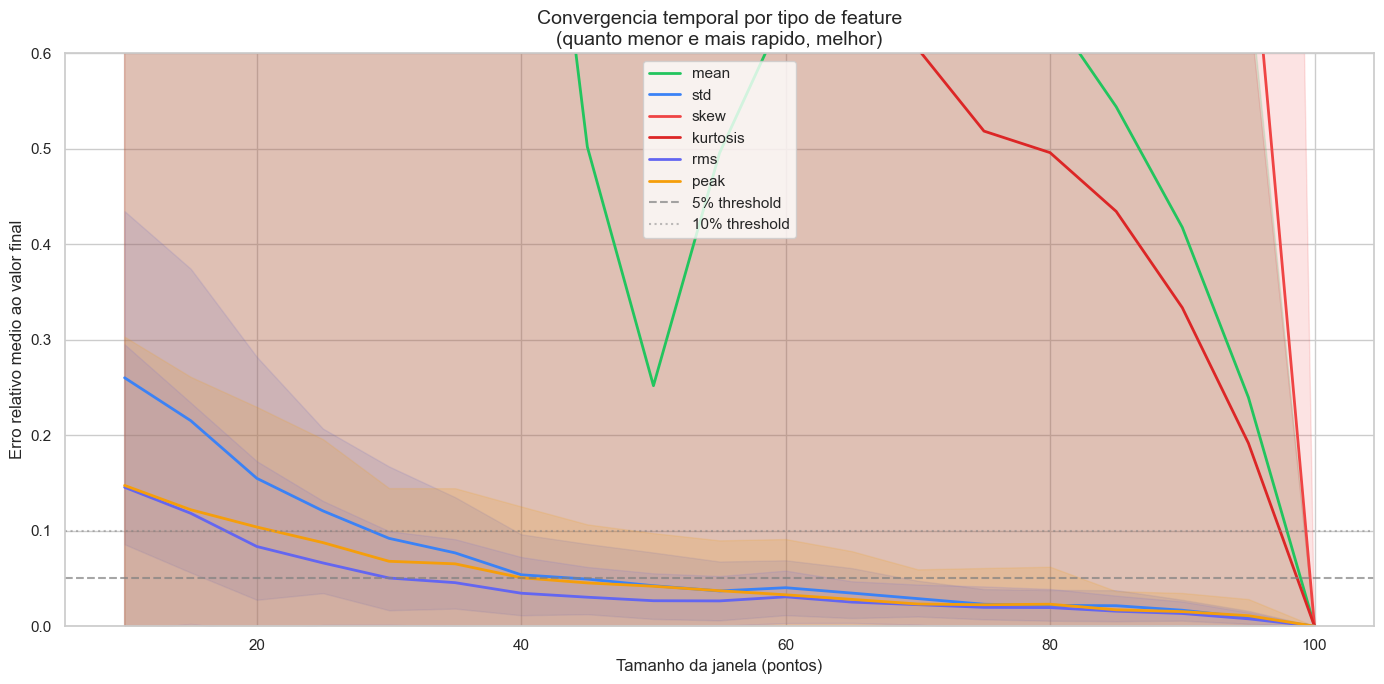


=== Pontos necessarios para erro < 5% ===
  mean           : 100 pontos (~20s)
  std            :  45 pontos (~9s)
  skew           : 100 pontos (~20s)
  kurtosis       : 100 pontos (~20s)
  rms            :  35 pontos (~7s)
  peak           :  45 pontos (~9s)


In [26]:
# =============================================================================
# Celula 5: Analise de convergencia temporal das features
#
# REQUER dados brutos (ponto-a-ponto). SKIP se DATA_SOURCE == 'features_only'.
# Simula janela deslizante crescente para medir quantos pontos cada tipo
# de feature precisa para convergir ao valor final (janela completa).
# =============================================================================

if df is None:
    print('SKIP: Analise de convergencia requer dados brutos (ponto-a-ponto).')
    print('      Rode com banco de dados ou CSV bruto para esta analise.')
    df_conv_agg = None
else:
    def compute_single_metric(arr, metric):
        """Calcula uma unica metrica para um array."""
        if len(arr) < 4:
            return np.nan
        if metric == 'mean':
            return np.mean(arr)
        elif metric == 'std':
            return np.std(arr, ddof=0)
        elif metric == 'skew':
            return float(skew(arr, bias=True))
        elif metric == 'kurtosis':
            return float(kurtosis(arr, fisher=True, bias=True))
        elif metric == 'rms':
            return np.sqrt(np.mean(arr ** 2))
        elif metric == 'peak':
            return np.percentile(np.abs(arr), 95)
        return np.nan

    metrics_to_analyze = ['mean', 'std', 'skew', 'kurtosis', 'rms', 'peak']
    window_sizes = list(range(10, WINDOW_SIZE + 1, 5))
    convergence_results = []

    for cls in ['LOW', 'MEDIUM', 'HIGH']:
        df_cls = df[df['fan_state'] == cls].reset_index(drop=True)
        offsets = [0, len(df_cls)//3, 2*len(df_cls)//3]

        for offset in offsets:
            if offset + WINDOW_SIZE > len(df_cls):
                continue
            full_window = df_cls.iloc[offset:offset + WINDOW_SIZE]

            for axis in SENSOR_AXES:
                full_arr = full_window[axis].values

                for metric in metrics_to_analyze:
                    final_val = compute_single_metric(full_arr, metric)
                    if np.isnan(final_val) or abs(final_val) < 1e-10:
                        continue

                    for ws in window_sizes:
                        partial_arr = full_arr[:ws]
                        partial_val = compute_single_metric(partial_arr, metric)
                        if np.isnan(partial_val):
                            continue

                        rel_error = abs(partial_val - final_val) / (abs(final_val) + 1e-10)
                        convergence_results.append({
                            'class': cls, 'axis': axis, 'metric': metric,
                            'window_size': ws, 'rel_error': rel_error, 'offset': offset,
                        })

    df_conv = pd.DataFrame(convergence_results)
    df_conv_agg = df_conv.groupby(['metric', 'window_size'])['rel_error'].agg(['mean', 'std']).reset_index()
    df_conv_agg.columns = ['metric', 'window_size', 'mean_error', 'std_error']

    # Plotar convergencia
    fig, ax = plt.subplots(figsize=(14, 7))
    colors_metric = {
        'mean': '#22c55e', 'std': '#3b82f6', 'rms': '#6366f1',
        'peak': '#f59e0b', 'skew': '#ef4444', 'kurtosis': '#dc2626'
    }

    for metric in metrics_to_analyze:
        subset = df_conv_agg[df_conv_agg['metric'] == metric]
        ax.plot(subset['window_size'], subset['mean_error'],
                label=metric, color=colors_metric.get(metric, 'gray'), linewidth=2)
        ax.fill_between(subset['window_size'],
                        subset['mean_error'] - subset['std_error'],
                        subset['mean_error'] + subset['std_error'],
                        alpha=0.15, color=colors_metric.get(metric, 'gray'))

    ax.axhline(y=0.05, color='gray', linestyle='--', alpha=0.7, label='5% threshold')
    ax.axhline(y=0.10, color='gray', linestyle=':', alpha=0.5, label='10% threshold')
    ax.set_xlabel('Tamanho da janela (pontos)', fontsize=12)
    ax.set_ylabel('Erro relativo medio ao valor final', fontsize=12)
    ax.set_title('Convergencia temporal por tipo de feature\n(quanto menor e mais rapido, melhor)', fontsize=14)
    ax.legend(fontsize=11)
    ax.set_ylim(0, 0.6)
    plt.tight_layout()
    fig.savefig(os.path.join(OUTPUT_FIGURES, '03v2_convergencia_temporal.png'), dpi=150)
    plt.show()

    print('\n=== Pontos necessarios para erro < 5% ===')
    for metric in metrics_to_analyze:
        subset = df_conv_agg[df_conv_agg['metric'] == metric]
        converged = subset[subset['mean_error'] < 0.05]
        if len(converged) > 0:
            min_ws = converged['window_size'].min()
            print(f'  {metric:15s}: {min_ws:3d} pontos (~{min_ws/SAMPLE_RATE_HZ:.0f}s)')
        else:
            print(f'  {metric:15s}: >100 pontos (nao convergiu)')

Features com variancia assimetrica (ratio > 3x): 41 de 66

Top 20 features por ratio de variancia HIGH/LOW:
  * accel_z_g_shape_factor                   H/L=   267.8  H/M=    75.1
  * accel_x_g_shape_factor                   H/L=    99.3  H/M=    19.5
  * accel_x_g_clearance_factor               H/L=    33.9  H/M=    15.2
  * accel_x_g_rms                            H/L=    29.6  H/M=     9.3
  * gyro_y_dps_peak                          H/L=    29.2  H/M=    16.2
  * gyro_x_dps_rms                           H/L=    25.6  H/M=    18.8
  * accel_x_g_mean                           H/L=    25.3  H/M=    10.4
  * gyro_x_dps_peak                          H/L=    25.1  H/M=    19.0
  * gyro_x_dps_std                           H/L=    23.3  H/M=    24.0
  * accel_x_g_root_amplitude                 H/L=    21.2  H/M=     9.6
  * gyro_y_dps_std                           H/L=    17.1  H/M=    18.5
  * gyro_y_dps_rms                           H/L=    18.0  H/M=    15.8
  * accel_z_g_std           

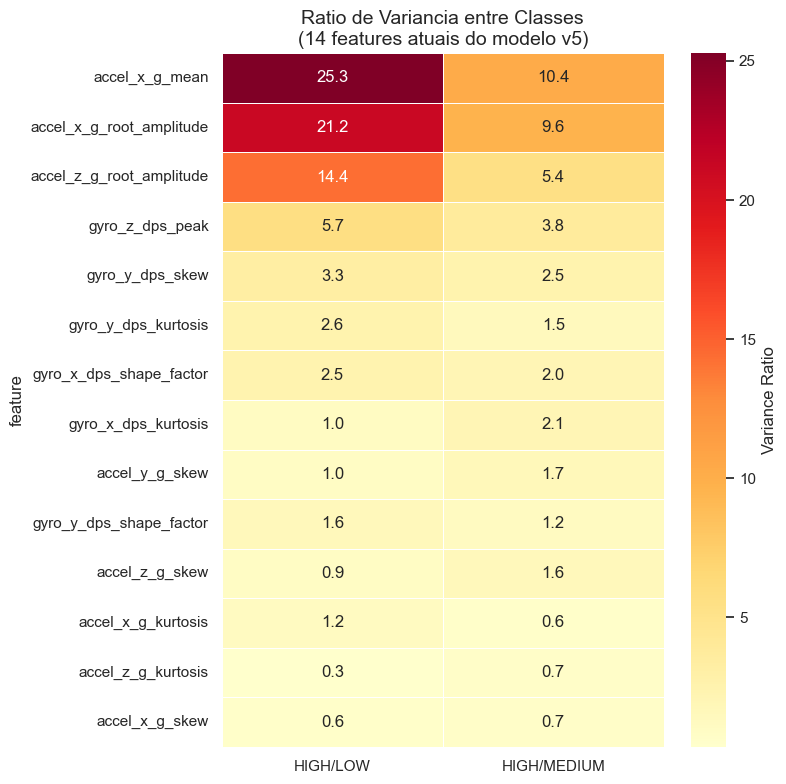

In [27]:
# =============================================================================
# Celula 6: Analise de variancia entre classes
#
# Identifica features com variancia assimetrica (HIGH >> LOW/MEDIUM)
# que causam a gaussiana mais larga de HIGH a "capturar" valores intermediarios
# =============================================================================

variance_ratios = []

for feat in feature_cols:
    var_by_class = {}
    for cls in ['LOW', 'MEDIUM', 'HIGH']:
        var_by_class[cls] = df_features[df_features['fan_state'] == cls][feat].var()
    
    # Evitar divisao por zero
    var_low = max(var_by_class['LOW'], 1e-10)
    var_med = max(var_by_class['MEDIUM'], 1e-10)
    var_high = max(var_by_class['HIGH'], 1e-10)
    
    variance_ratios.append({
        'feature': feat,
        'var_LOW': var_by_class['LOW'],
        'var_MEDIUM': var_by_class['MEDIUM'],
        'var_HIGH': var_by_class['HIGH'],
        'ratio_HIGH_LOW': var_high / var_low,
        'ratio_HIGH_MEDIUM': var_high / var_med,
        'max_ratio': max(var_high / var_low, var_high / var_med),
    })

df_var_ratios = pd.DataFrame(variance_ratios).sort_values('max_ratio', ascending=False)

# Features com variancia assimetrica (ratio > 3x)
asymmetric_features = df_var_ratios[df_var_ratios['max_ratio'] > 3]['feature'].tolist()
print(f'Features com variancia assimetrica (ratio > 3x): {len(asymmetric_features)} de {len(feature_cols)}')
print()
print('Top 20 features por ratio de variancia HIGH/LOW:')
for _, row in df_var_ratios.head(20).iterrows():
    asym = '*' if row['max_ratio'] > 3 else ' '
    print(f'  {asym} {row["feature"]:40s} H/L={row["ratio_HIGH_LOW"]:8.1f}  H/M={row["ratio_HIGH_MEDIUM"]:8.1f}')

# Heatmap de ratios
# Selecionar features das 14 atuais para ver o problema
current_14 = [
    'gyro_z_dps_peak', 'gyro_y_dps_skew', 'accel_x_g_skew', 'accel_z_g_skew',
    'accel_x_g_kurtosis', 'gyro_x_dps_shape_factor', 'gyro_y_dps_kurtosis',
    'gyro_y_dps_shape_factor', 'accel_x_g_root_amplitude', 'accel_z_g_kurtosis',
    'accel_y_g_skew', 'accel_x_g_mean', 'accel_z_g_root_amplitude', 'gyro_x_dps_kurtosis'
]

df_heatmap = df_var_ratios[df_var_ratios['feature'].isin(current_14)].set_index('feature')
df_heatmap = df_heatmap[['ratio_HIGH_LOW', 'ratio_HIGH_MEDIUM']]
df_heatmap.columns = ['HIGH/LOW', 'HIGH/MEDIUM']

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Variance Ratio'})
ax.set_title('Ratio de Variancia entre Classes\n(14 features atuais do modelo v5)', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '03v2_variancia_assimetrica_heatmap.png'), dpi=150)
plt.show()

In [28]:
# =============================================================================
# Celula 7: Selecao de features com restricao de convergencia
#
# Ranking consensual (ANOVA + KW + MI) com penalizacao para features
# de alta ordem (skew/kurtosis) que convergem lentamente.
# Gera 3 conjuntos candidatos: A (baseline), B (max 3 skew/kurtosis), C (zero).
# =============================================================================

# --- 1. ANOVA F-test ---
anova_results = []
for feat in feature_cols:
    groups = [df_features[df_features['fan_state'] == cls][feat].dropna().values
              for cls in ['LOW', 'MEDIUM', 'HIGH']]
    if all(len(g) > 1 for g in groups):
        f_stat, p_val = scipy_stats.f_oneway(*groups)
        anova_results.append({'feature': feat, 'f_statistic': f_stat, 'p_value': p_val})

df_anova = pd.DataFrame(anova_results).sort_values('f_statistic', ascending=False)
df_significant = df_anova[df_anova['p_value'] < ANOVA_ALPHA].copy()

# --- 2. Kruskal-Wallis ---
kw_results = []
for feat in feature_cols:
    groups = [df_features[df_features['fan_state'] == cls][feat].dropna().values
              for cls in ['LOW', 'MEDIUM', 'HIGH']]
    if all(len(g) > 1 for g in groups):
        h_stat, p_val = kruskal(*groups)
        kw_results.append({'feature': feat, 'h_statistic': h_stat, 'p_value': p_val})

df_kw = pd.DataFrame(kw_results).sort_values('h_statistic', ascending=False)

# --- 3. Mutual Information ---
le = LabelEncoder()
y_encoded = le.fit_transform(df_features['fan_state'])
X_features = df_features[feature_cols]
mi_scores = mutual_info_classif(X_features, y_encoded, random_state=42)
df_mi = pd.DataFrame({'feature': feature_cols, 'mi_score': mi_scores}).sort_values('mi_score', ascending=False)

# --- 4. Ranking consensual ---
df_ranking = pd.DataFrame({'feature': feature_cols})
anova_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_anova.iterrows())}
kw_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_kw.iterrows())}
mi_rank = {row['feature']: i+1 for i, (_, row) in enumerate(df_mi.iterrows())}

df_ranking['anova_rank'] = df_ranking['feature'].map(anova_rank)
df_ranking['kw_rank'] = df_ranking['feature'].map(kw_rank)
df_ranking['mi_rank'] = df_ranking['feature'].map(mi_rank)
df_ranking['avg_rank'] = df_ranking[['anova_rank', 'kw_rank', 'mi_rank']].mean(axis=1)

# Classificar tipo de feature
def get_feature_order(feat_name):
    """Retorna a 'ordem' da feature: 1 (mean/rms), 2 (std/peak/root_amplitude), 3 (skew), 4 (kurtosis)."""
    for suffix, order in [('_kurtosis', 4), ('_skew', 3), ('_std', 2), ('_peak', 2),
                          ('_rms', 2), ('_root_amplitude', 2), ('_mean', 1),
                          ('_crest_factor', 2), ('_shape_factor', 2),
                          ('_impulse_factor', 2), ('_clearance_factor', 2)]:
        if feat_name.endswith(suffix):
            return order
    return 2

df_ranking['feature_order'] = df_ranking['feature'].apply(get_feature_order)
df_ranking['is_high_order'] = df_ranking['feature_order'] >= 3
df_ranking = df_ranking.sort_values('avg_rank')

# --- 5. Filtro de correlacao ---
significant_features = df_significant['feature'].tolist()
corr_matrix = df_features[significant_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_remove_corr = set()
for col in upper.columns:
    correlated = upper.index[upper[col] > CORRELATION_THRESHOLD].tolist()
    for corr_feat in correlated:
        f_col = df_anova[df_anova['feature'] == col]['f_statistic'].values[0]
        f_corr = df_anova[df_anova['feature'] == corr_feat]['f_statistic'].values[0]
        if f_corr < f_col:
            to_remove_corr.add(corr_feat)
        else:
            to_remove_corr.add(col)

# Features candidatas (significativas, nao correlacionadas)
candidate_features = [f for f in significant_features if f not in to_remove_corr]
# Ordenar pelo ranking consensual
rank_map = {row['feature']: row['avg_rank'] for _, row in df_ranking.iterrows()}
candidate_features.sort(key=lambda f: rank_map.get(f, 999))

print(f'Features significativas: {len(df_significant)}')
print(f'Removidas por correlacao: {len(to_remove_corr)}')
print(f'Candidatas finais: {len(candidate_features)}')

# --- 6. Gerar 3 conjuntos ---
# A: Baseline (todas as candidatas, ~14 features)
set_A = candidate_features[:14]  # top 14 pelo ranking

# B: Max 3 skew/kurtosis
high_order = [f for f in candidate_features if get_feature_order(f) >= 3]
low_order = [f for f in candidate_features if get_feature_order(f) < 3]
set_B = low_order[:11] + high_order[:3]  # ate 14 features, max 3 high-order
set_B.sort(key=lambda f: rank_map.get(f, 999))
set_B = set_B[:14]

# C: Zero skew/kurtosis
set_C = low_order[:14]

print(f'\n=== Conjunto A (baseline): {len(set_A)} features ===')
for i, f in enumerate(set_A, 1):
    order = get_feature_order(f)
    tag = ' [HIGH-ORDER]' if order >= 3 else ''
    print(f'  {i:2d}. {f}{tag}')
n_ho_A = sum(1 for f in set_A if get_feature_order(f) >= 3)
print(f'  -> {n_ho_A} skew/kurtosis features ({100*n_ho_A/len(set_A):.0f}%)')

print(f'\n=== Conjunto B (max 3 skew/kurtosis): {len(set_B)} features ===')
for i, f in enumerate(set_B, 1):
    order = get_feature_order(f)
    tag = ' [HIGH-ORDER]' if order >= 3 else ''
    print(f'  {i:2d}. {f}{tag}')
n_ho_B = sum(1 for f in set_B if get_feature_order(f) >= 3)
print(f'  -> {n_ho_B} skew/kurtosis features ({100*n_ho_B/len(set_B):.0f}%)')

print(f'\n=== Conjunto C (zero skew/kurtosis): {len(set_C)} features ===')
for i, f in enumerate(set_C, 1):
    print(f'  {i:2d}. {f}')
print(f'  -> 0 skew/kurtosis features')

Features significativas: 64
Removidas por correlacao: 46
Candidatas finais: 18

=== Conjunto A (baseline): 14 features ===
   1. accel_x_g_std
   2. gyro_z_dps_shape_factor
   3. gyro_y_dps_kurtosis [HIGH-ORDER]
   4. gyro_x_dps_shape_factor
   5. gyro_x_dps_kurtosis [HIGH-ORDER]
   6. accel_y_g_kurtosis [HIGH-ORDER]
   7. gyro_y_dps_skew [HIGH-ORDER]
   8. accel_z_g_root_amplitude
   9. accel_x_g_kurtosis [HIGH-ORDER]
  10. gyro_z_dps_skew [HIGH-ORDER]
  11. gyro_y_dps_mean
  12. gyro_x_dps_skew [HIGH-ORDER]
  13. accel_x_g_mean
  14. gyro_z_dps_mean
  -> 7 skew/kurtosis features (50%)

=== Conjunto B (max 3 skew/kurtosis): 12 features ===
   1. accel_x_g_std
   2. gyro_z_dps_shape_factor
   3. gyro_y_dps_kurtosis [HIGH-ORDER]
   4. gyro_x_dps_shape_factor
   5. gyro_x_dps_kurtosis [HIGH-ORDER]
   6. accel_y_g_kurtosis [HIGH-ORDER]
   7. accel_z_g_root_amplitude
   8. gyro_y_dps_mean
   9. accel_x_g_mean
  10. gyro_z_dps_mean
  11. accel_y_g_mean
  12. accel_y_g_crest_factor
  -> 3 sk

A (baseline): 100.00% (+/- 0.00%)  [14 features, 7 skew/kurt]
B (max 3 skew/kurt): 100.00% (+/- 0.00%)  [12 features, 3 skew/kurt]
C (zero skew/kurt): 100.00% (+/- 0.00%)  [9 features, 0 skew/kurt]


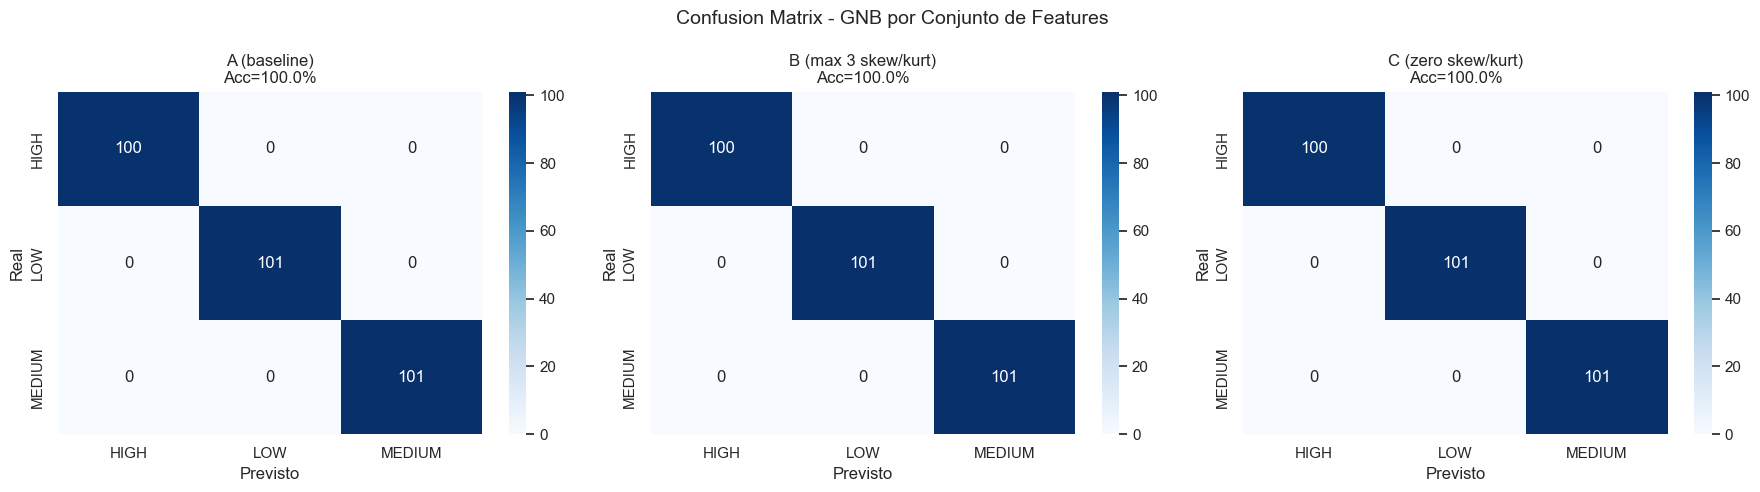

In [29]:
# =============================================================================
# Celula 8: Treino comparativo GNB para cada conjunto
#
# Cross-validation 5-fold para comparar acuracia dos 3 conjuntos.
# =============================================================================

feature_sets = {'A (baseline)': set_A, 'B (max 3 skew/kurt)': set_B, 'C (zero skew/kurt)': set_C}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_cv = {}

for name, feat_list in feature_sets.items():
    X = df_features[feat_list].values
    y = y_encoded
    
    gnb = GaussianNB()
    scores = cross_val_score(gnb, X, y, cv=cv, scoring='accuracy')
    results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores,
        'n_features': len(feat_list),
        'n_high_order': sum(1 for f in feat_list if get_feature_order(f) >= 3),
    }
    print(f'{name}: {scores.mean()*100:.2f}% (+/- {scores.std()*100:.2f}%)  [{len(feat_list)} features, {results_cv[name]["n_high_order"]} skew/kurt]')

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
class_names = le.classes_

for idx, (name, feat_list) in enumerate(feature_sets.items()):
    X = df_features[feat_list].values
    y = y_encoded
    
    gnb = GaussianNB()
    gnb.fit(X, y)
    y_pred = gnb.predict(X)
    
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=class_names, yticklabels=class_names)
    axes[idx].set_title(f'{name}\nAcc={results_cv[name]["mean"]*100:.1f}%')
    axes[idx].set_ylabel('Real')
    axes[idx].set_xlabel('Previsto')

plt.suptitle('Confusion Matrix - GNB por Conjunto de Features', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '03v2_confusion_matrix_comparison.png'), dpi=150)
plt.show()

A (baseline):
  Sem scaler:  100.00% (+/- 0.00%)
  Com scaler:  100.00% (+/- 0.00%)
  Delta:       +0.00%

B (max 3 skew/kurt):
  Sem scaler:  100.00% (+/- 0.00%)
  Com scaler:  100.00% (+/- 0.00%)
  Delta:       +0.00%

C (zero skew/kurt):
  Sem scaler:  100.00% (+/- 0.00%)
  Com scaler:  100.00% (+/- 0.00%)
  Delta:       +0.00%



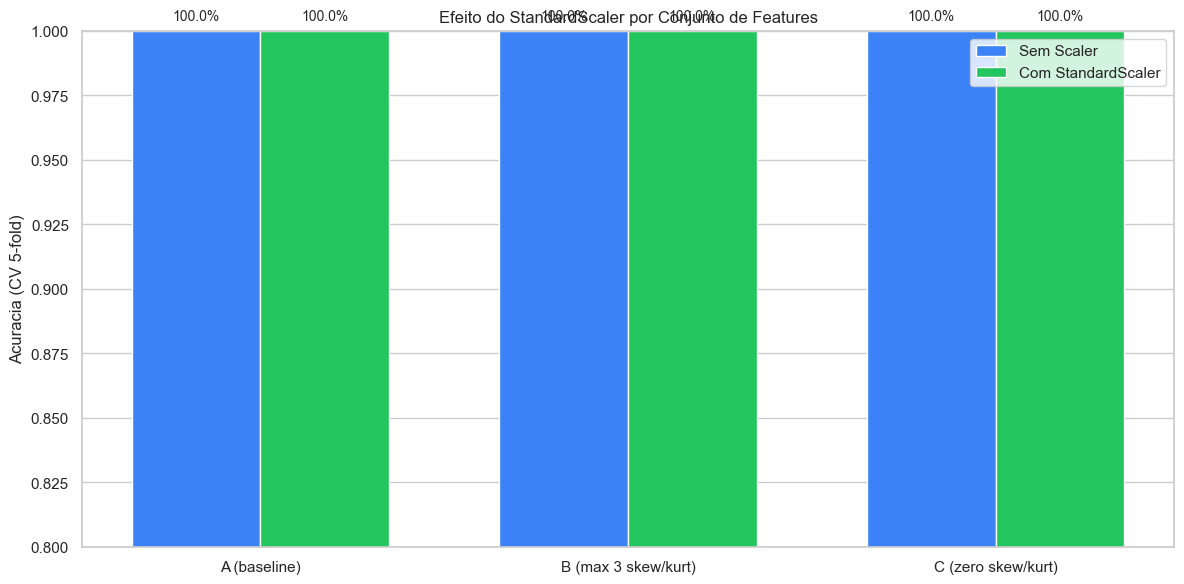

In [30]:
# =============================================================================
# Celula 9: Treino com StandardScaler + GNB
#
# Aplica StandardScaler antes do GNB para equalizar variancias entre classes.
# Se melhorar: exporta media/std do scaler junto com o modelo.
# =============================================================================

results_scaled = {}

for name, feat_list in feature_sets.items():
    X_raw = df_features[feat_list].values
    y = y_encoded
    
    # Sem scaler (baseline)
    gnb_raw = GaussianNB()
    scores_raw = cross_val_score(gnb_raw, X_raw, y, cv=cv, scoring='accuracy')
    
    # Com scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    gnb_scaled = GaussianNB()
    scores_scaled = cross_val_score(gnb_scaled, X_scaled, y, cv=cv, scoring='accuracy')
    
    results_scaled[name] = {
        'raw_mean': scores_raw.mean(),
        'raw_std': scores_raw.std(),
        'scaled_mean': scores_scaled.mean(),
        'scaled_std': scores_scaled.std(),
        'improvement': scores_scaled.mean() - scores_raw.mean(),
    }
    
    delta = results_scaled[name]['improvement'] * 100
    arrow = '+' if delta >= 0 else ''
    print(f'{name}:')
    print(f'  Sem scaler:  {scores_raw.mean()*100:.2f}% (+/- {scores_raw.std()*100:.2f}%)')
    print(f'  Com scaler:  {scores_scaled.mean()*100:.2f}% (+/- {scores_scaled.std()*100:.2f}%)')
    print(f'  Delta:       {arrow}{delta:.2f}%')
    print()

# Barplot comparativo
fig, ax = plt.subplots(figsize=(12, 6))
names = list(results_scaled.keys())
x = np.arange(len(names))
width = 0.35

raw_means = [results_scaled[n]['raw_mean'] for n in names]
scaled_means = [results_scaled[n]['scaled_mean'] for n in names]

bars1 = ax.bar(x - width/2, raw_means, width, label='Sem Scaler', color='#3b82f6')
bars2 = ax.bar(x + width/2, scaled_means, width, label='Com StandardScaler', color='#22c55e')

ax.set_ylabel('Acuracia (CV 5-fold)')
ax.set_title('Efeito do StandardScaler por Conjunto de Features')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.set_ylim(0.8, 1.0)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.003,
            f'{bar.get_height()*100:.1f}%', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.003,
            f'{bar.get_height()*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FIGURES, '03v2_scaler_comparison.png'), dpi=150)
plt.show()

In [31]:
# =============================================================================
# Celula 10: Simulacao de transicao
#
# REQUER dados brutos (ponto-a-ponto). SKIP se DATA_SOURCE == 'features_only'.
# Usa dados reais para simular transicoes HIGH->MEDIUM->LOW
# e LOW->MEDIUM->HIGH, medindo tempo de convergencia da predicao.
# =============================================================================

df_transitions = None

if df is None:
    print('SKIP: Simulacao de transicao requer dados brutos (ponto-a-ponto).')
    print('      Rode com banco de dados ou CSV bruto para esta analise.')
    print('      As celulas 11/11b usarao apenas acuracia CV para selecao do modelo.')
else:
    def simulate_transition(df_from, df_to, feat_list, model, label_encoder, use_scaler=False, scaler=None):
        """Simula uma transicao abrupta: buffer cheio de 'from', novos pontos de 'to'."""
        from_arr = df_from.reset_index(drop=True)
        to_arr = df_to.reset_index(drop=True)

        buffer = from_arr.iloc[:WINDOW_SIZE].copy()
        target_class = to_arr['fan_state'].iloc[0]
        results = []
        max_points = min(len(to_arr), WINDOW_SIZE * 2)

        for i in range(max_points):
            buffer = pd.concat([buffer.iloc[1:], to_arr.iloc[[i]]], ignore_index=True)
            if len(buffer) < WINDOW_SIZE:
                continue

            feat_dict = {}
            for axis in SENSOR_AXES:
                feat_dict.update(compute_features_v2(buffer[axis].values, axis))

            X_point = np.array([[feat_dict[f] for f in feat_list]])
            if use_scaler and scaler is not None:
                X_point = scaler.transform(X_point)

            pred_idx = model.predict(X_point)[0]
            pred_class = label_encoder.inverse_transform([pred_idx])[0]
            proba = model.predict_proba(X_point)[0]

            results.append({
                'point': i,
                'time_s': i / SAMPLE_RATE_HZ,
                'prediction': pred_class,
                'correct': pred_class == target_class,
                'prob_LOW': proba[list(label_encoder.classes_).index('LOW')],
                'prob_MEDIUM': proba[list(label_encoder.classes_).index('MEDIUM')],
                'prob_HIGH': proba[list(label_encoder.classes_).index('HIGH')],
            })
        return pd.DataFrame(results)

    # Preparar dados por classe
    df_by_class = {}
    for cls in ['LOW', 'MEDIUM', 'HIGH']:
        df_by_class[cls] = df[df['fan_state'] == cls].reset_index(drop=True)

    transitions = [
        ('HIGH', 'LOW'), ('LOW', 'HIGH'),
        ('HIGH', 'MEDIUM'), ('MEDIUM', 'HIGH'),
        ('MEDIUM', 'LOW'), ('LOW', 'MEDIUM'),
    ]

    # Simular para cada conjunto + com/sem scaler
    configs = []
    for name, feat_list in feature_sets.items():
        X_train = df_features[feat_list].values
        gnb = GaussianNB()
        gnb.fit(X_train, y_encoded)
        configs.append((name, feat_list, gnb, False, None))

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train)
        gnb_scaled = GaussianNB()
        gnb_scaled.fit(X_scaled, y_encoded)
        configs.append((f'{name} +Scaler', feat_list, gnb_scaled, True, scaler))

    all_transition_results = []
    for config_name, feat_list, model, use_scaler, scaler in configs:
        for from_cls, to_cls in transitions:
            df_sim = simulate_transition(
                df_by_class[from_cls], df_by_class[to_cls],
                feat_list, model, le, use_scaler, scaler
            )

            convergence_point = None
            for j in range(len(df_sim) - 2):
                if (df_sim.iloc[j]['correct'] and
                    df_sim.iloc[j+1]['correct'] and
                    df_sim.iloc[j+2]['correct']):
                    convergence_point = df_sim.iloc[j]['time_s']
                    break

            all_transition_results.append({
                'config': config_name,
                'transition': f'{from_cls}->{to_cls}',
                'from': from_cls, 'to': to_cls,
                'convergence_s': convergence_point if convergence_point is not None else float('inf'),
                'converged': convergence_point is not None,
            })

    df_transitions = pd.DataFrame(all_transition_results)

    print('=== Tempo de Convergencia por Transicao (segundos) ===')
    pivot = df_transitions.pivot_table(
        index='config', columns='transition', values='convergence_s', aggfunc='first'
    )
    print(pivot.round(1).to_string())

    print('\n=== Assimetria (ratio subida/descida) ===')
    for config_name in df_transitions['config'].unique():
        cfg = df_transitions[df_transitions['config'] == config_name]
        h2l = cfg[cfg['transition'] == 'HIGH->LOW']['convergence_s'].values[0]
        l2h = cfg[cfg['transition'] == 'LOW->HIGH']['convergence_s'].values[0]

        if l2h > 0 and h2l < float('inf') and l2h < float('inf'):
            ratio = h2l / l2h
            print(f'  {config_name:35s}: H->L={h2l:5.1f}s  L->H={l2h:5.1f}s  ratio={ratio:.2f}x')
        else:
            print(f'  {config_name:35s}: H->L={h2l:5.1f}s  L->H={l2h:5.1f}s  (nao convergiu)')

=== Tempo de Convergencia por Transicao (segundos) ===
transition                   HIGH->LOW  HIGH->MEDIUM  LOW->HIGH  LOW->MEDIUM  MEDIUM->HIGH  MEDIUM->LOW
config                                                                                                 
A (baseline)                      19.6          15.4        1.2          7.8           3.8          2.6
A (baseline) +Scaler              19.6          15.4        1.2          7.8           3.8          2.6
B (max 3 skew/kurt)               19.6          17.2        1.4          7.8           3.0          2.4
B (max 3 skew/kurt) +Scaler       19.6          17.2        1.4          7.8           3.0          2.4
C (zero skew/kurt)                19.4          16.4        5.4         18.0           5.4          1.4
C (zero skew/kurt) +Scaler        19.4          16.4        5.4         18.0           5.4          1.4

=== Assimetria (ratio subida/descida) ===
  A (baseline)                       : H->L= 19.6s  L->H=  1.2s  ratio

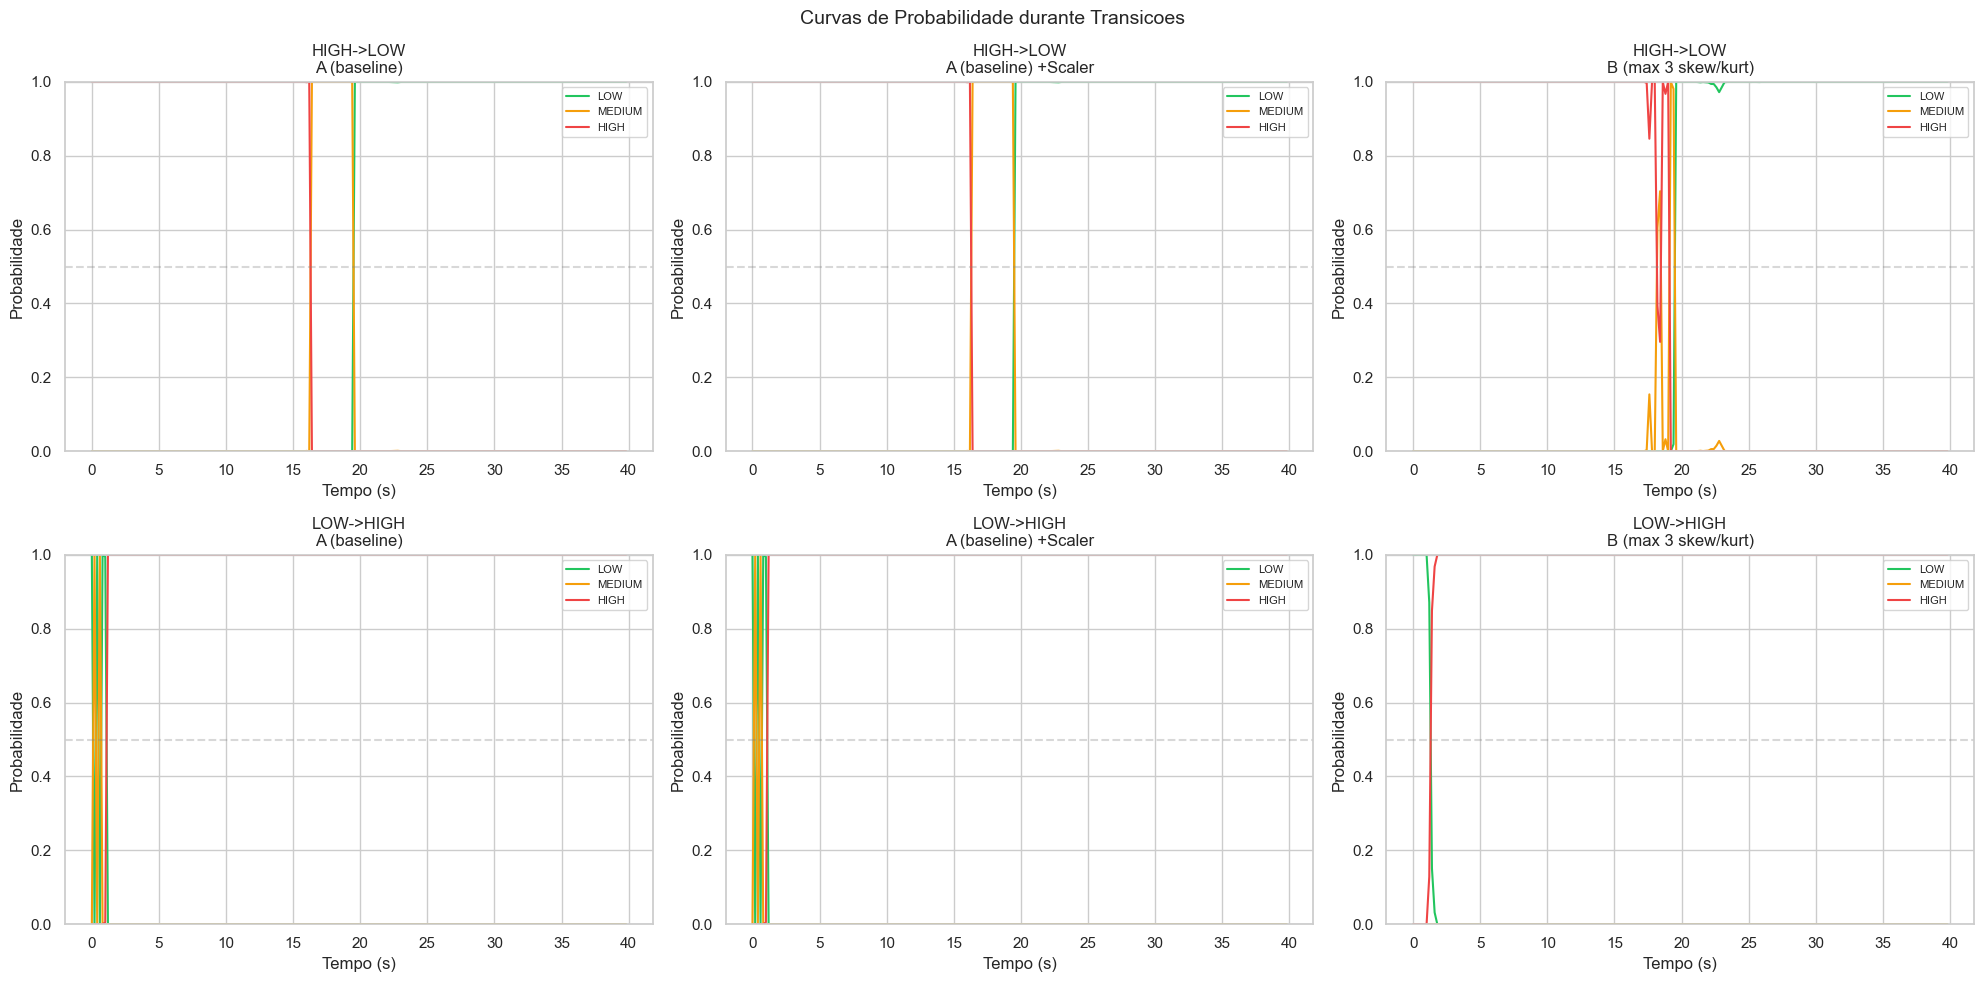

In [32]:
# =============================================================================
# Celula 10b: Plotar curvas de probabilidade das transicoes HIGH<->LOW
# SKIP se DATA_SOURCE == 'features_only'
# =============================================================================

if df is None or df_transitions is None:
    print('SKIP: Graficos de transicao requerem dados brutos.')
else:
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    key_transitions = [('HIGH', 'LOW'), ('LOW', 'HIGH')]

    for row, (from_cls, to_cls) in enumerate(key_transitions):
        for col, (config_name, feat_list, model, use_scaler, scaler) in enumerate(configs[:3]):
            df_sim = simulate_transition(
                df_by_class[from_cls], df_by_class[to_cls],
                feat_list, model, le, use_scaler, scaler
            )

            ax = axes[row][col]
            ax.plot(df_sim['time_s'], df_sim['prob_LOW'], color='#22c55e', label='LOW', linewidth=1.5)
            ax.plot(df_sim['time_s'], df_sim['prob_MEDIUM'], color='#f59e0b', label='MEDIUM', linewidth=1.5)
            ax.plot(df_sim['time_s'], df_sim['prob_HIGH'], color='#ef4444', label='HIGH', linewidth=1.5)
            ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.3)
            ax.set_ylim(0, 1)
            ax.set_xlabel('Tempo (s)')
            ax.set_ylabel('Probabilidade')
            ax.set_title(f'{from_cls}->{to_cls}\n{config_name}')
            ax.legend(fontsize=8)

    plt.suptitle('Curvas de Probabilidade durante Transicoes', fontsize=14)
    plt.tight_layout()
    fig.savefig(os.path.join(OUTPUT_FIGURES, '03v2_transition_curves.png'), dpi=150)
    plt.show()

In [33]:
# =============================================================================
# Celula 11: Recomendacao final e exportacao
#
# Seleciona o melhor conjunto baseado em:
# 1. Acuracia CV (deve ser >= 95%)
# 2. Simetria de transicao (se dados brutos disponiveis)
# 3. Tempo medio de convergencia (se dados brutos disponiveis)
# =============================================================================

# Construir configs se nao existirem (modo features_only)
if 'configs' not in dir() or not configs:
    configs = []
    for name, feat_list in feature_sets.items():
        X_train = df_features[feat_list].values
        gnb = GaussianNB()
        gnb.fit(X_train, y_encoded)
        configs.append((name, feat_list, gnb, False, None))

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train)
        gnb_scaled = GaussianNB()
        gnb_scaled.fit(X_scaled, y_encoded)
        configs.append((f'{name} +Scaler', feat_list, gnb_scaled, True, scaler))

# Compilar metricas para selecao
selection_metrics = []

for config_name, feat_list, model, use_scaler, scaler in configs:
    X_cfg = df_features[feat_list].values
    if use_scaler and scaler is not None:
        X_cfg = scaler.transform(X_cfg)
    scores = cross_val_score(model, X_cfg, y_encoded, cv=cv, scoring='accuracy')

    # Transicoes (se disponiveis)
    if df_transitions is not None:
        cfg_trans = df_transitions[df_transitions['config'] == config_name]
        h2l = cfg_trans[cfg_trans['transition'] == 'HIGH->LOW']['convergence_s'].values[0]
        l2h = cfg_trans[cfg_trans['transition'] == 'LOW->HIGH']['convergence_s'].values[0]
        converged_trans = cfg_trans[cfg_trans['converged']]
        avg_conv = converged_trans['convergence_s'].mean() if len(converged_trans) > 0 else float('inf')

        if h2l < float('inf') and l2h < float('inf') and l2h > 0:
            asymmetry = max(h2l/l2h, l2h/h2l)
        else:
            asymmetry = float('inf')
    else:
        h2l = l2h = avg_conv = float('nan')
        asymmetry = 1.0  # sem dados, assumir simetrico

    selection_metrics.append({
        'config': config_name,
        'features': feat_list,
        'model': model,
        'use_scaler': use_scaler,
        'scaler': scaler,
        'cv_mean': scores.mean(),
        'cv_std': scores.std(),
        'asymmetry': asymmetry,
        'avg_convergence_s': avg_conv,
        'h2l_s': h2l,
        'l2h_s': l2h,
        'n_features': len(feat_list),
    })

df_selection = pd.DataFrame(selection_metrics)

# Score composto
if df_transitions is not None:
    df_selection['score'] = (
        df_selection['cv_mean'] * 100
        - df_selection['asymmetry'].replace(float('inf'), 50) * 2
        - df_selection['avg_convergence_s'].replace(float('inf'), 100) * 0.5
    )
else:
    # Sem dados de transicao: score = acuracia + bonus por menos high-order features
    df_selection['score'] = df_selection['cv_mean'] * 100
    for idx, row in df_selection.iterrows():
        n_ho = sum(1 for f in row['features'] if get_feature_order(f) >= 3)
        df_selection.at[idx, 'score'] -= n_ho * 0.5  # penalidade leve por high-order

df_selection = df_selection.sort_values('score', ascending=False)

print('=== Ranking Final ===')
for _, row in df_selection.iterrows():
    asym_str = f'{row["asymmetry"]:.2f}x' if not np.isnan(row['asymmetry']) and row['asymmetry'] != float('inf') else 'N/A'
    conv_str = f'{row["avg_convergence_s"]:.1f}s' if not np.isnan(row['avg_convergence_s']) else 'N/A'
    print(f'  {row["config"]:35s}  CV={row["cv_mean"]*100:.1f}%  '
          f'Asym={asym_str:>6s}  AvgConv={conv_str:>6s}  '
          f'Score={row["score"]:.1f}')

best = df_selection.iloc[0]
print(f'\n>>> MELHOR: {best["config"]}  (Score={best["score"]:.1f})')
print(f'    CV: {best["cv_mean"]*100:.1f}% (+/- {best["cv_std"]*100:.1f}%)')
if df_transitions is not None:
    print(f'    Assimetria: {best["asymmetry"]:.2f}x')
    print(f'    Convergencia media: {best["avg_convergence_s"]:.1f}s')
    print(f'    H->L: {best["h2l_s"]:.1f}s  L->H: {best["l2h_s"]:.1f}s')
else:
    print('    (Dados de transicao nao disponiveis - rode com banco/CSV bruto para analise completa)')

=== Ranking Final ===
  C (zero skew/kurt)                   CV=100.0%  Asym= 3.59x  AvgConv= 11.0s  Score=87.3
  C (zero skew/kurt) +Scaler           CV=100.0%  Asym= 3.59x  AvgConv= 11.0s  Score=87.3
  B (max 3 skew/kurt)                  CV=100.0%  Asym=14.00x  AvgConv=  8.6s  Score=67.7
  B (max 3 skew/kurt) +Scaler          CV=100.0%  Asym=14.00x  AvgConv=  8.6s  Score=67.7
  A (baseline)                         CV=100.0%  Asym=16.33x  AvgConv=  8.4s  Score=63.1
  A (baseline) +Scaler                 CV=100.0%  Asym=16.33x  AvgConv=  8.4s  Score=63.1

>>> MELHOR: C (zero skew/kurt)  (Score=87.3)
    CV: 100.0% (+/- 0.0%)
    Assimetria: 3.59x
    Convergencia media: 11.0s
    H->L: 19.4s  L->H: 5.4s


In [34]:
# =============================================================================
# Celula 11b: Exportar modelo final
# =============================================================================

best_features = best['features']
best_use_scaler = best['use_scaler']
best_scaler = best['scaler']

# Retreinar com todos os dados
X_final = df_features[best_features].values
y_final = y_encoded

if best_use_scaler and best_scaler is not None:
    final_scaler = StandardScaler()
    X_final_scaled = final_scaler.fit_transform(X_final)
    final_model = GaussianNB()
    final_model.fit(X_final_scaled, y_final)
    X_for_eval = X_final_scaled
else:
    final_scaler = None
    final_model = GaussianNB()
    final_model.fit(X_final, y_final)
    X_for_eval = X_final

# Exportar modelo JSON
train_acc = accuracy_score(y_final, final_model.predict(X_for_eval))
cv_scores_final = cross_val_score(final_model, X_for_eval, y_final, cv=5)

asym_val = float(best['asymmetry']) if not np.isnan(best['asymmetry']) else None
conv_val = float(best['avg_convergence_s']) if not np.isnan(best['avg_convergence_s']) else None

export_data = {
    'type': 'gaussian_nb',
    'version': f'py_v2_{time.strftime("%Y%m%d")}',
    'generated_at': time.strftime('%Y-%m-%d %H:%M:%S'),
    'generated_by': '03_EDA_v2_Transicao_Simetrica.ipynb',
    'features': list(best_features),
    'labels': list(le.classes_),
    'priors': {},
    'stats': {},
    'metrics': {
        'train_accuracy': float(train_acc),
        'cv_accuracy_mean': float(cv_scores_final.mean()),
        'cv_accuracy_std': float(cv_scores_final.std()),
    },
    'training_info': {
        'total_samples': len(X_final),
        'window_size': WINDOW_SIZE,
        'peak_method': 'P95' if DATA_SOURCE != 'features_only' else 'max_abs (CSV fallback)',
        'feature_set': best['config'],
        'data_source': DATA_SOURCE,
        'n_high_order_features': sum(1 for f in best_features if get_feature_order(f) >= 3),
    },
}

if asym_val is not None:
    export_data['metrics']['asymmetry_ratio'] = asym_val
if conv_val is not None:
    export_data['metrics']['avg_convergence_s'] = conv_val

# Priors
priors = final_model.class_prior_ if hasattr(final_model, 'class_prior_') else final_model.class_count_ / final_model.class_count_.sum()
for i, label in enumerate(le.classes_):
    export_data['priors'][label] = float(priors[i])

# Stats (mean/var)
for i, label in enumerate(le.classes_):
    export_data['stats'][label] = {}
    for j, feature in enumerate(best_features):
        export_data['stats'][label][feature] = {
            'mean': float(final_model.theta_[i, j]),
            'var': float(final_model.var_[i, j]),
        }

# Scaler params (se usado)
if final_scaler is not None:
    export_data['scaler'] = {
        'type': 'standard',
        'mean': {feat: float(final_scaler.mean_[j]) for j, feat in enumerate(best_features)},
        'scale': {feat: float(final_scaler.scale_[j]) for j, feat in enumerate(best_features)},
    }
    print('NOTA: Modelo usa StandardScaler. classifier.js precisara normalizar features.')

# Salvar modelo
model_filename = f'gnb_model_v2_{time.strftime("%Y%m%d")}.json'
model_path = os.path.join(OUTPUT_MODELS, model_filename)
with open(model_path, 'w') as f:
    json.dump(export_data, f, indent=2)
print(f'Modelo salvo: {os.path.abspath(model_path)}')

# Copiar para pasta models/ na raiz
root_model_path = os.path.join('..', 'models', model_filename)
os.makedirs(os.path.dirname(root_model_path), exist_ok=True)
with open(root_model_path, 'w') as f:
    json.dump(export_data, f, indent=2)
print(f'Copiado para: {os.path.abspath(root_model_path)}')

# Atualizar feature_config.json
feature_config = {
    'version': '4.0',
    'generated_by': '03_EDA_v2_Transicao_Simetrica.ipynb',
    'generated_at': TIMESTAMP_STR,
    'selection_criteria': {
        'anova_alpha': ANOVA_ALPHA,
        'correlation_threshold': CORRELATION_THRESHOLD,
        'method': 'consensus_ranking_with_convergence_filter',
        'peak_method': 'P95',
    },
    'window_size': WINDOW_SIZE,
    'step_size': STEP_SIZE,
    'selected_features': list(best_features),
    'all_features': feature_cols,
    'feature_count': len(best_features),
    'total_feature_count': len(feature_cols),
    'class_distribution': {k: int(v) for k, v in df_features['fan_state'].value_counts().to_dict().items()},
    'sensor_axes': SENSOR_AXES,
    'feature_metrics': ['mean', 'std', 'skew', 'kurtosis', 'rms', 'peak',
                        'root_amplitude', 'crest_factor', 'shape_factor',
                        'impulse_factor', 'clearance_factor'],
}

if final_scaler is not None:
    feature_config['scaler'] = export_data['scaler']

config_path = os.path.join(CONFIG_DIR, 'feature_config.json')
with open(config_path, 'w') as f:
    json.dump(feature_config, f, indent=2)
print(f'Feature config salvo: {os.path.abspath(config_path)}')

print(f'\n=== CONCLUIDO ===')
print(f'Modelo: {model_filename}')
print(f'Features: {len(best_features)}')
print(f'Config: {best["config"]}')
print(f'CV Accuracy: {best["cv_mean"]*100:.1f}%')
print(f'Fonte de dados: {DATA_SOURCE}')
if DATA_SOURCE == 'features_only':
    print(f'\nAVISO: Modelo treinado com features pre-extraidas (peak=max_abs).')
    print(f'       Para alinhamento perfeito com classifier.js (peak=P95),')
    print(f'       recoletar dados e rodar com banco ou CSV bruto.')
print(f'\n--- Proximos passos ---')
print(f'1. Atualizar MODEL_URL em js/dashboard.js para: models/{model_filename}')
if final_scaler is not None:
    print(f'2. Adaptar classifier.js para normalizar features com scaler (media/scale no modelo JSON)')
print(f'3. Testar no dashboard com teste guiado de transicao')

Modelo salvo: c:\xampp\htdocs\XAMPP_iot_mpu_6050\notebooks\output\models\gnb_model_v2_20260131.json
Copiado para: c:\xampp\htdocs\XAMPP_iot_mpu_6050\models\gnb_model_v2_20260131.json
Feature config salvo: c:\xampp\htdocs\XAMPP_iot_mpu_6050\config\feature_config.json

=== CONCLUIDO ===
Modelo: gnb_model_v2_20260131.json
Features: 9
Config: C (zero skew/kurt)
CV Accuracy: 100.0%
Fonte de dados: db

--- Proximos passos ---
1. Atualizar MODEL_URL em js/dashboard.js para: models/gnb_model_v2_20260131.json
3. Testar no dashboard com teste guiado de transicao
